In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import re
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import tree
import sklearn
from sklearn import ensemble
from scipy.stats import rankdata
#import plotly.plotly as py
#import plotly.graph_objs as go

In [3]:
movies = pd.read_csv('dataset.csv')

In [4]:
# New column names
new_cols = []
for col in movies.columns:  
    new_cols.append(col.strip())

movies.columns = new_cols

# Displaying df
movies.head(3)

,name,genre,timeCinema,contentRating,company,duration,synopsis,rating,box-office
0,102 Dalmatians,"['Comedy', 'Kids & Family']",2000-11-21T16:00:00-08:00,G,Buena Vista Pictures,P100M,"\n In this all new tale, Cruella De Vil is ...",31,"$65,406,212"
1,The 6th Day,"['Action & Adventure', 'Mystery & Suspense', '...",2000-11-16T16:00:00-08:00,PG13,Columbia Pictures,P123M,\n In this science-fiction thriller set in ...,41,"$33,813,823"
2,The Adventures of Rocky & Bullwinkle,"['Comedy', 'Kids & Family', 'Science Fiction &...",2000-06-29T17:00:00-07:00,PG,Universal Pictures,P92M,\n The pride of Frostbite Falls and Whatsam...,43,"$411,840"


In [5]:
movies = movies.drop_duplicates()
movies = movies.reset_index(drop = True)

In [6]:
# Converting the date in a readable format
timeCin = []
missing = []
for index,time_date in enumerate(movies['timeCinema']):
    pos = max(time_date.find('T'), 0)

    if (pos == 0):
        missing.append(index)
    else:
        timeCin.append((time_date[:pos].strip()))
        
    
#Dropping the data with missing dates
bad_movies = movies.index.isin(missing)

movies = movies[~bad_movies]    
movies = movies.reset_index(drop=True)

print ('Now feature is converted to :' , timeCin[0])       

Now feature is converted to : 2000-11-21


In [7]:
year = []
month = []
day = []
date_col = []

for time_date in timeCin:
    date = dt.strptime(time_date, "%Y-%m-%d")
    date_col.append(date)
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    
# Check for errors in each of the lists by printing unique values and length
for col in [year,month,day]: 
    print ('Unique values' , np.unique(np.array(col)))
    
if ((len(year)==len(month))&(len(month)==len(day))):   
    print ('OK: all newly created features have the same length')
    
else:
    print ('Error: newly created features do not have the same length')
    
# Creating new time-related features
movies['date'] = date_col
movies['year'] = year
movies['month'] = month
movies['day'] = day

#Splitting days in weeks of the month
first_week = np.zeros(movies['day'].shape[0])
second_week = np.zeros(movies['day'].shape[0])
third_week = np.zeros(movies['day'].shape[0])

for index, day in enumerate(movies['day']):
    
    if (day <= 7):
        first_week[index]+=1
        
    elif (day > 8 and day <= 14):
        second_week[index]+=1
    
    elif (day > 14 and day <= 21):
        third_week[index]+=1
        
    else:
        pass
        
movies['first_week'] = first_week
movies['second_week'] = second_week
movies['third_week'] = third_week

# Removing the superfluous features
movies.drop(['day', 'timeCinema'], axis = 1, inplace = True)

# Removing all movies prior to 2000
old = movies[movies['year'] < 2000]
old_ind = old.index.values
movies.drop(old_ind, inplace = True)

#Removing all movies post 2018-3
new = movies[movies['date'] >= dt(2018, 4, 1)]
new_ind = new.index.values
movies.drop(new_ind, inplace = True)
movies = movies.reset_index(drop=True)
movies.drop(['date'], axis = 1, inplace = True)

Unique values [1975 1987 1990 1991 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
Unique values [ 1  2  3  4  5  6  7  8  9 10 11 12]
Unique values [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
OK: all newly created features have the same length


In [8]:
movies.head()

,name,genre,contentRating,company,duration,synopsis,rating,box-office,year,month,first_week,second_week,third_week
0,102 Dalmatians,"['Comedy', 'Kids & Family']",G,Buena Vista Pictures,P100M,"\n In this all new tale, Cruella De Vil is ...",31,"$65,406,212",2000,11,0.0,0.0,1.0
1,The 6th Day,"['Action & Adventure', 'Mystery & Suspense', '...",PG13,Columbia Pictures,P123M,\n In this science-fiction thriller set in ...,41,"$33,813,823",2000,11,0.0,0.0,1.0
2,The Adventures of Rocky & Bullwinkle,"['Comedy', 'Kids & Family', 'Science Fiction &...",PG,Universal Pictures,P92M,\n The pride of Frostbite Falls and Whatsam...,43,"$411,840",2000,6,0.0,0.0,0.0
3,All the Pretty Horses,"['Drama', 'Mystery & Suspense']",PG13,Miramax,P116M,\n Texas teenager John Grady Cole finds him...,32,"$14,713,716",2000,12,0.0,0.0,0.0
4,Almost Famous,"['Comedy', 'Drama']",R,DreamWorks SKG,P123M,\n Writer and director Cameron Crowe's expe...,89,"$31,716,715",2000,9,0.0,1.0,0.0


In [9]:
#Motivation: after viewing the unique values there are some time date ones instead of duration + some with 2000 which we remove
duration = []
missing = []
for index,dur in enumerate(movies['duration']):
    
    if (dur.find('T')!=-1):
        missing.append(index)
        
    elif ((dur == 'P2000M')or(dur == 'P1M')):
        missing.append(index)
        
    else:       
        newstr = dur.replace("M", "")
        newstr = newstr.replace("P", "")
        duration.append(int(newstr))

bad_df = movies.index.isin(missing)

movies = movies[~bad_df]    

print ('\nNow feature is converted to :' , duration[0])  

movies['duration'] = duration
movies = movies.reset_index(drop=True)


Now feature is converted to : 100


In [10]:
# Setting the genre of the movies to 0-1 variables
n = len(movies["genre"])

unique_genres = []
for i in range(n):
    movies.loc[i,"genre"] = movies.loc[i,"genre"].replace("['","")
    movies.loc[i,"genre"] = movies.loc[i,"genre"].replace("', '", " -- ")
    movies.loc[i,"genre"] = movies.loc[i,"genre"].replace("']", " ")
    genres = movies.loc[i,"genre"].split(" -- ")
    for genre in genres:
        if not (genre in unique_genres):
            unique_genres.append(genre)

for i in range(len(unique_genres)):
    unique_genres[i] = unique_genres[i].rstrip()
    
unique_genres.remove('[]')

for genre in unique_genres:
    movies[genre] = np.zeros(n)
    
for i in range(n):
    for gen in unique_genres:
        if gen in movies.loc[i,"genre"]:
            movies.loc[i, gen] = 1
                       
# Droping genre column
movies = movies.drop(['genre'],axis = 1)

In [11]:
movies = movies.reset_index(drop = True)
movies.head()

,name,contentRating,company,duration,synopsis,rating,box-office,year,month,first_week,...,Romance,Sports & Fitness,Musical & Performing Arts,Western,Documentary,Classics,Special Interest,Cult Movies,Faith & Spirituality,Gay & Lesbian
0,102 Dalmatians,G,Buena Vista Pictures,100,"\n In this all new tale, Cruella De Vil is ...",31,"$65,406,212",2000,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The 6th Day,PG13,Columbia Pictures,123,\n In this science-fiction thriller set in ...,41,"$33,813,823",2000,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Adventures of Rocky & Bullwinkle,PG,Universal Pictures,92,\n The pride of Frostbite Falls and Whatsam...,43,"$411,840",2000,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,All the Pretty Horses,PG13,Miramax,116,\n Texas teenager John Grady Cole finds him...,32,"$14,713,716",2000,12,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Almost Famous,R,DreamWorks SKG,123,\n Writer and director Cameron Crowe's expe...,89,"$31,716,715",2000,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


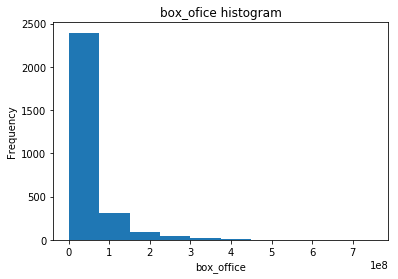

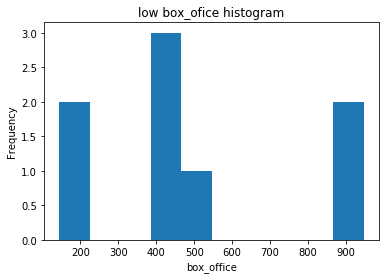

In [12]:
box = []
missing = []

for index,mon in enumerate(movies['box-office']):
    if (mon.find('$')==-1):
        missing.append(index)
        
    else:
        new_mon = mon.replace("$", "")
        new_mon = new_mon.replace(",", "")
        box.append(int(new_mon))

#Let's now use a histogram to see what's going (since unique does not help)
plt.hist(box)
plt.title("box_ofice histogram")
plt.xlabel("box_office")
plt.ylabel("Frequency")

fig = plt.gcf()
plt.show()

#Let's see for those that are less than 1000
box = np.array(box)
low_box = box[box<1000]

plt.hist(low_box)
plt.title("low box_ofice histogram")
plt.xlabel("box_office")
plt.ylabel("Frequency")
fig = plt.gcf()
plt.show()

In [13]:
#Merging with original set to find the low box office movies
movies['box-office'] = box
movies[movies['box-office']<1000]

#Rotten tomatoes error -> removing them
#movies = movies.drop(movies[movies['box-office']<1000].index,axis = 0)

,name,contentRating,company,duration,synopsis,rating,box-office,year,month,first_week,...,Romance,Sports & Fitness,Musical & Performing Arts,Western,Documentary,Classics,Special Interest,Cult Movies,Faith & Spirituality,Gay & Lesbian
1835,I Spit on Your Grave 2,R,Anchor Bay Entertainment,106,"\n A woman is brutally raped by four men, a...",0,441,2013,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2574,Burke and Hare,R,IFC Films,91,"\n From John Landis, the director of Animal...",32,947,2011,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2601,The Decoy Bride,PG,IFC Films,89,\n When the wedding of internationally famo...,23,542,2012,3,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2669,Hammer Of The Gods,R,Magnolia Pictures,99,"\n Set in Viking Britain in 871 AD, Hammer ...",29,411,2013,7,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2753,Detour,R,Bankside Films,85,"\n Harper (Tye Sheridan), a seemingly naive...",64,145,2017,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2857,Stations of the Cross,NR,Film Movement,107,"\n Told in fourteen fixed-angle, single sho...",92,159,2015,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2865,United Passions,NR,Screen Media Films,110,"\n Gérard Depardieu, Sam Neill and Tim Roth...",0,900,2015,6,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2874,A Perfect Man,R,IFC Films,95,\n Liev Schreiber (X-Men Origins: Wolverine...,20,388,2013,10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
movies.head(3)

,name,contentRating,company,duration,synopsis,rating,box-office,year,month,first_week,...,Romance,Sports & Fitness,Musical & Performing Arts,Western,Documentary,Classics,Special Interest,Cult Movies,Faith & Spirituality,Gay & Lesbian
0,102 Dalmatians,G,Buena Vista Pictures,100,"\n In this all new tale, Cruella De Vil is ...",31,65406212,2000,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The 6th Day,PG13,Columbia Pictures,123,\n In this science-fiction thriller set in ...,41,33813823,2000,11,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Adventures of Rocky & Bullwinkle,PG,Universal Pictures,92,\n The pride of Frostbite Falls and Whatsam...,43,411840,2000,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Sort movies by title so that you get the sequels and not the first movie
movies = movies.sort_values(by=['name']).reset_index(drop=True)

titles = set()
common = set()
numbers = set(['1','2','3','4','5','6','7','8','9'])
sequel = np.zeros(movies['name'].shape[0])

for index,name in enumerate(movies['name']):
    new_name = re.sub('[1234567890 ]', '', name)
    if (new_name in titles and new_name!='' and new_name != '/' and name[-1] in numbers):
        common.add(new_name)
        sequel[index]+=1
    
    else:        
        titles.add(new_name)
        
print (common)
    
#movies['isSequel'] = sequel 

#movies[movies['isSequel']==1]['name']

#There are a lot of subcases that it does not work but whatever

{'Ted', 'ScaryMovie', 'Rio', 'HarryPotterandtheDeathlyHallows-Part', 'TheExpendables', 'FinalDestination', 'IronMan', 'Red', 'KungFuPanda', 'ParanormalActivity', 'AHauntedHouse', 'TheSmurfs', 'CheaperbytheDozen', 'WolfCreek', 'DespicableMe', 'Cars', 'MyBigFatGreekWedding', 'SexandtheCity', 'HorribleBosses', 'NowYouSeeMe', 'Spider-Man', 'HowtoTrainYourDragon', 'TheConjuring', 'Zoolander', 'StepUp', 'Shrek', 'GrownUps', 'Taken', 'Fast&Furious', 'PitchPerfect'}


In [16]:
#Merging with rain and temperature
temp = pd.read_csv('temp.csv',header = None)
rain = pd.read_csv('rain.csv',header = None)
unemp = pd.read_csv('unemployment.csv', header = None)

print (unemp.head())

rain.drop([2], axis = 1, inplace = True)
temp.drop([2], axis = 1, inplace = True)

year = []
month = []

for index,element in enumerate(rain[0]):
    year.append(element//100)
    month.append(element%100)

rain.drop([0],axis = 1 , inplace = True)
rain['year'] = year
rain['month'] = month
rain = rain.rename( columns={1: "rain"})

year = []
month = []

for index,element in enumerate(temp[0]):
    year.append(element//100)
    month.append(element%100)

temp.drop([0],axis = 1 , inplace = True)
temp['year'] = year
temp['month'] = month
temp = temp.rename( columns={1: "temperature"})

year = []
month = []

for index,element in enumerate(unemp[0]):
    year.append(element//100)
    month.append(element%100)

unemp.drop([0],axis = 1 , inplace = True)
unemp['year'] = year
unemp['month'] = month
unemp = unemp.rename( columns={1: "unemployment"})

unemp.head()

#Merging with temperature and rain
movies = movies.merge(temp, left_on=['year','month'], right_on=['year','month'], how='left')
movies = movies.merge(unemp, left_on=['year','month'], right_on=['year','month'], how='left')
movies = movies.merge(rain, left_on=['year','month'], right_on=['year','month'], how='left')

#Checking to see if the merge was done correctly
movies.iloc[0,:]

        0    1
0  200001  4.0
1  200002  4.1
2  200003  4.0
3  200004  3.8
4  200005  4.0


name                                                                       '71
contentRating                                                             PG13
company                                                   Roadside Attractions
duration                                                                   100
synopsis                     \n    '71 takes place over a single night in t...
rating                                                                      95
box-office                                                             1286219
year                                                                      2015
month                                                                        2
first_week                                                                   0
second_week                                                                  0
third_week                                                                   0
Comedy                                              

In [17]:
#One hot vector encoding for contentRating company and year,month,day ##Excluding company
movies = pd.get_dummies(movies, prefix=None, prefix_sep='_', columns=['contentRating','year','month'], drop_first=True)

In [18]:
# Getting the 'importance' of the studios
studios = pd.read_csv("companies.csv",encoding='latin-1')
studios.head()
movies = movies.merge(studios, left_on='company', right_on='Original', how='left')
movies.drop(['company', 'Original'], axis = 1, inplace = True )

In [19]:
print(movies.columns)

Index(['name', 'duration', 'synopsis', 'rating', 'box-office', 'first_week',
       'second_week', 'third_week', 'Comedy', 'Kids & Family',
       'Action & Adventure', 'Mystery & Suspense', 'Science Fiction & Fantasy',
       'Drama', 'Television', 'Horror', 'Animation', 'Anime & Manga',
       'Art House & International', 'Romance', 'Sports & Fitness',
       'Musical & Performing Arts', 'Western', 'Documentary', 'Classics',
       'Special Interest', 'Cult Movies', 'Faith & Spirituality',
       'Gay & Lesbian', 'temperature', 'unemployment', 'rain',
       'contentRating_NC17', 'contentRating_NR', 'contentRating_PG',
       'contentRating_PG13', 'contentRating_R', 'year_2001', 'year_2002',
       'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007',
       'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017',
       'year_2018', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
      

In [20]:
movies.head()

,name,duration,synopsis,rating,box-office,first_week,second_week,third_week,Comedy,Kids & Family,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Mini-Major,Major
0,'71,100,\n '71 takes place over a single night in t...,95,1286219,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,10 Cloverfield Lane,90,\n A young woman wakes up after a terrible ...,90,59481553,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,10 Items or Less,81,\n An aging Hollywood icon whose fear of fa...,63,69265,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0.0,0.0
3,"10,000 B.C.",109,\n A young outcast from a primitive tribe i...,8,94700000,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,1.0
4,102 Dalmatians,100,"\n In this all new tale, Cruella De Vil is ...",31,65406212,0.0,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.0,1.0


In [21]:
# Checking for NaN
print(movies.isnull().sum())
print("\n")
movies[movies['Major'].isnull()]

name                         0
duration                     0
synopsis                     0
rating                       0
box-office                   0
first_week                   0
second_week                  0
third_week                   0
Comedy                       0
Kids & Family                0
Action & Adventure           0
Mystery & Suspense           0
Science Fiction & Fantasy    0
Drama                        0
Television                   0
Horror                       0
Animation                    0
Anime & Manga                0
Art House & International    0
Romance                      0
Sports & Fitness             0
Musical & Performing Arts    0
Western                      0
Documentary                  0
Classics                     0
Special Interest             0
Cult Movies                  0
Faith & Spirituality         0
Gay & Lesbian                0
temperature                  0
                            ..
year_2002                    0
year_200

,name,duration,synopsis,rating,box-office,first_week,second_week,third_week,Comedy,Kids & Family,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Mini-Major,Major
640,Detour,85,"\n Harper (Tye Sheridan), a seemingly naive...",64,145,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [22]:
movies.drop(640,inplace = True)
movies = movies.reset_index(drop = True)

In [23]:
# No NaN
movies.columns

Index(['name', 'duration', 'synopsis', 'rating', 'box-office', 'first_week',
       'second_week', 'third_week', 'Comedy', 'Kids & Family',
       'Action & Adventure', 'Mystery & Suspense', 'Science Fiction & Fantasy',
       'Drama', 'Television', 'Horror', 'Animation', 'Anime & Manga',
       'Art House & International', 'Romance', 'Sports & Fitness',
       'Musical & Performing Arts', 'Western', 'Documentary', 'Classics',
       'Special Interest', 'Cult Movies', 'Faith & Spirituality',
       'Gay & Lesbian', 'temperature', 'unemployment', 'rain',
       'contentRating_NC17', 'contentRating_NR', 'contentRating_PG',
       'contentRating_PG13', 'contentRating_R', 'year_2001', 'year_2002',
       'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007',
       'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017',
       'year_2018', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
      

# Training phase

## Define features and response - split in train and test

In [24]:
X = movies.drop(['name','box-office','synopsis'],axis = 1)
y = movies.loc[:,'box-office']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X.head()
print (X.shape,y.shape)

(2888, 65) (2888,)


## The input matrix has columns that are linearly dependent 

## Linear regression

In [25]:
# Create linear regression object
print ('\nFiting linear regression on the data')
regr = linear_model.LinearRegression()

print ('\nTraining')
# Train the model using the training sets
regr.fit(X_train, y_train)

# Get training error 
R = regr.score(X_train, y_train)
print ('\nIn sample R**2 is :', R)

# Out of sample error
R_out = regr.score(X_test,y_test)
print ('\nOut of sample R**2 is :', R_out)



Fiting linear regression on the data

Training

In sample R**2 is : 0.4597837180237896

Out of sample R**2 is : 0.4065492922637657


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Scaling features

In [26]:
X_scaled = pd.DataFrame(preprocessing.scale(X))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)


## Ridge regression


Fiting ridge regression on the data


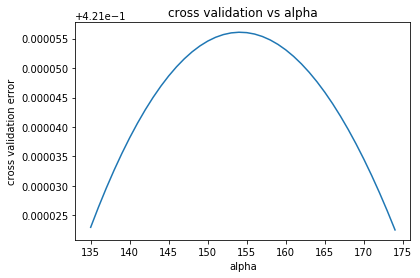


 best alpha is : 154.0 with average cross validation score :  0.42105608556136725


NameError: name 'best_model' is not defined

In [27]:
print ('\nFiting ridge regression on the data')

#Creating grid for search 
grid = np.arange(135,175,1)
cross_val = np.zeros((grid.shape[0],2))

for index,l in enumerate(grid):
    
    ridge_reg = sk.linear_model.Ridge(alpha=l )
    scores = cross_val_score(ridge_reg, X_train, y_train, cv=5)
    avg_score = sum(scores)/len(scores)
    cross_val[index,0] = l
    cross_val[index,1] += avg_score
    
best_index = np.argmax(cross_val[:,1])
plt.plot(cross_val[:,0],cross_val[:,1])
plt.xlabel('alpha')
plt.ylabel('cross validation error')
plt.title('cross validation vs alpha')
plt.show()

print ('\n best alpha is :', cross_val[best_index,0], 'with average cross validation score : ',cross_val[best_index,1])
# Out of sample error
best_model_rid = sk.linear_model.Ridge(alpha= cross_val[best_index,0])
best_model_rid.fit(X_train,y_train)

R_out = best_model.score(X_test,y_test)
print ('\nOut of sample R**2 for ridge regression with alpha = ',  cross_val[best_index,0], 'is: ', R_out)

## Lasso regression


Fiting lasso regression on the data


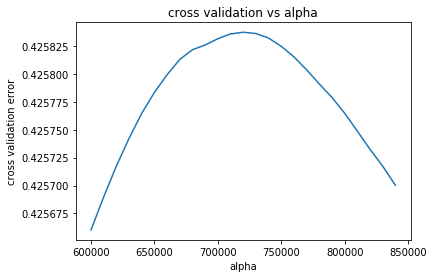


 best alpha is : 720000.0 with average cross validation score :  0.4258371770784294


NameError: name 'best_model' is not defined

In [28]:
print ('\nFiting lasso regression on the data')


#Creating grid for search 
grid = np.arange(600000,850000,10000)
cross_val = np.zeros((grid.shape[0],2))

for index,l in enumerate(grid):
    
    lasso_reg = sk.linear_model.Lasso(alpha=l, max_iter = 10000 )
    scores = cross_val_score(lasso_reg, X_train, y_train, cv=5)
    avg_score = sum(scores)/len(scores)
    cross_val[index,0] = l
    cross_val[index,1] += avg_score
    
best_index = np.argmax(cross_val[:,1])
plt.plot(cross_val[:,0],cross_val[:,1])
plt.xlabel('alpha')
plt.ylabel('cross validation error')
plt.title('cross validation vs alpha')
plt.show()

print ('\n best alpha is :', cross_val[best_index,0], 'with average cross validation score : ',cross_val[best_index,1])
# Out of sample error
best_model_las = sk.linear_model.Lasso(alpha= cross_val[best_index,0])
best_model_las.fit(X_train,y_train)

R_out = best_model.score(X_test,y_test)
print ('\nOut of sample R**2 for lasso regression with alpha = ',  cross_val[best_index,0], 'is: ', R_out)
zero_weight_features = X_test.columns[best_model.coef_.astype('int')==0]
print ('The features that were set to zero are :', list(zero_weight_features))

### Interpreting results 

For this I think we need to know which column was deleted in the first place

## Elastic net 

In [231]:
l1_ratio_grid = np.arange(0.7,1,0.05)
a_grid = np.arange(150000,1000000,10000)
cross_score = np.zeros((l1_ratio_grid.shape[0],a_grid.shape[0]))

for index_ratio,l1 in enumerate(l1_ratio_grid):
    
    for index_a,a in enumerate(a_grid):
        
        net = linear_model.ElasticNet(alpha=a, l1_ratio=l1)
        scores = cross_val_score(net, X_train, y_train, cv=5)
        avg_score = sum(scores)/len(scores)
        cross_score[index_ratio,index_a] = avg_score

        
ind = np.unravel_index(np.argmax(cross_score, axis=None), cross_score.shape)
l1_best = l1_ratio_grid[ind[0]]
a_best = a_grid[ind[1]]
print ('best combination of grid is (l1, a)', l1_best, a_best)

best_model_net = sk.linear_model.ElasticNet(alpha= a_best, l1_ratio = l1_best)
best_model_net.fit(X_train,y_train)

R_out = best_model.score(X_test,y_test)
print (R_out)

best combination of grid is (l1, a) 1.0 720000
0.410575422469


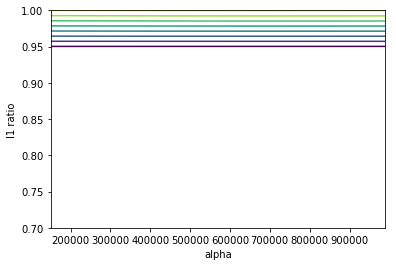

In [232]:
fig = plt.figure()
X_grid, Y_grid = np.meshgrid(a_grid, l1_ratio_grid)
plt.contour(X_grid,Y_grid,cross_score)
plt.xlabel('alpha')
plt.ylabel('l1 ratio')
plt.show()

### Interpreting results 

Best one is lasso

## Regression Tree

Reloading unscaled data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [30]:
#Criterion = MSE, splitter = best , min_impurity_split = None
max_depth_grid = np.arange(2,20,1)
min_samples_split_grid = np.arange(2,10,1)
cross_score = np.zeros((max_depth_grid.shape[0],min_samples_split_grid.shape[0]))

for index_1,m_depth in enumerate(max_depth_grid):
    
    for index_2,m_samples in enumerate(min_samples_split_grid):
        
        tree = sklearn.tree.DecisionTreeRegressor( max_depth=m_depth, min_samples_split=m_samples)
        scores = cross_val_score(tree, X_train, y_train, cv=5)
        avg_score = sum(scores)/len(scores)
        cross_score[index_1,index_2] = avg_score

        
ind = np.unravel_index(np.argmax(cross_score, axis=None), cross_score.shape)
best_max_depth = max_depth_grid[ind[0]]
best_min_samples_split = min_samples_split_grid[ind[1]]

best_model_tree = sklearn.tree.DecisionTreeRegressor( max_depth=best_max_depth, min_samples_split=best_min_samples_split)
best_model_tree.fit(X_train,y_train)

score = best_model_tree.score(X_test,y_test)
print ('best combination of hyperparameters for regression tree is  (max_depth, min_samples_split)', best_max_depth, best_min_samples_split, 'with out of sample R**2 :', score)


best combination of hyperparameters for regression tree is  (max_depth, min_samples_split) 5 3 with out of sample R**2 : 0.21634941411611175


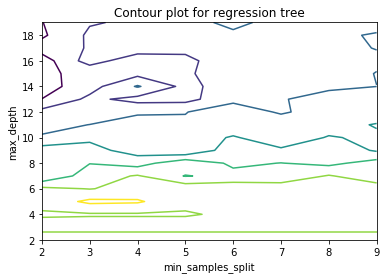

In [31]:
fig = plt.figure()
X_grid, Y_grid = np.meshgrid(min_samples_split_grid,max_depth_grid)
plt.contour(X_grid,Y_grid,cross_score)
plt.title('Contour plot for regression tree')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()

### Visualization

If someone could visualize the tree itself

Note: Someone could change the min_bucket(min_leaf) to get better results

In [40]:
from sklearn.tree import export_graphviz
export_graphviz(best_model_tree, feature_names=X_train.columns.tolist())


/usr/local/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


## Random forest

A word on the hyperparameters we chose to grid over. For our tree we chose to generate 200 tree in each iteration with minimum samples on each leaf(equivalent to minimum backet) = 5 and minimum samples split = 10. We chose to iterate on maximum tree depth and maximum features chosen. The criterion we chose was MSE and we did not include minimum or maximum impurity gain.

In [236]:
max_depth_grid = np.arange(15,25,1)
n_estim_grid = np.arange(15,25,1)
cross_score = np.zeros((max_depth_grid.shape[0],n_estim_grid.shape[0]))

for index_1,m_depth in enumerate(max_depth_grid):
    
    for index_2,n_estim in enumerate(n_estim_grid):
        
        forest = sklearn.ensemble.RandomForestRegressor(n_estimators=200 , max_depth=m_depth, min_samples_split=10, min_samples_leaf=5, max_features=n_estim)
        scores = cross_val_score(forest, X_train, y_train, cv=5)
        avg_score = sum(scores)/len(scores)
        cross_score[index_1,index_2] = avg_score

        
ind = np.unravel_index(np.argmax(cross_score, axis=None), cross_score.shape)
best_max_depth = max_depth_grid[ind[0]]
best_n_estim = n_estim_grid[ind[1]]

best_model_rf = sklearn.ensemble.RandomForestRegressor(n_estimators=200 , max_depth=best_max_depth, min_samples_split=10, min_samples_leaf=5, max_features=best_n_estim)
best_model_rf.fit(X_train,y_train)

score = best_model_rf.score(X_test,y_test)
print ('best combination of hyperparameters for random forest is  (max_depth, n_estim)', best_max_depth, best_n_estim, 'with out of sample R**2 :', score)


best combination of hyperparameters for random forest is  (max_depth, n_estim) 20 23 with out of sample R**2 : 0.510298721064


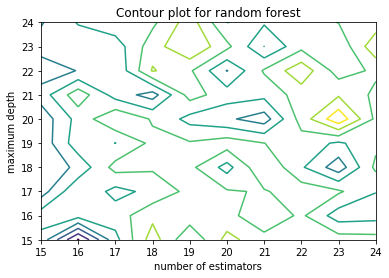

In [237]:
fig = plt.figure()
X_grid, Y_grid = np.meshgrid(n_estim_grid,max_depth_grid)
plt.contour(X_grid,Y_grid,cross_score)
plt.xlabel('number of estimators')
plt.ylabel('maximum depth')
plt.title('Contour plot for random forest')
plt.show()

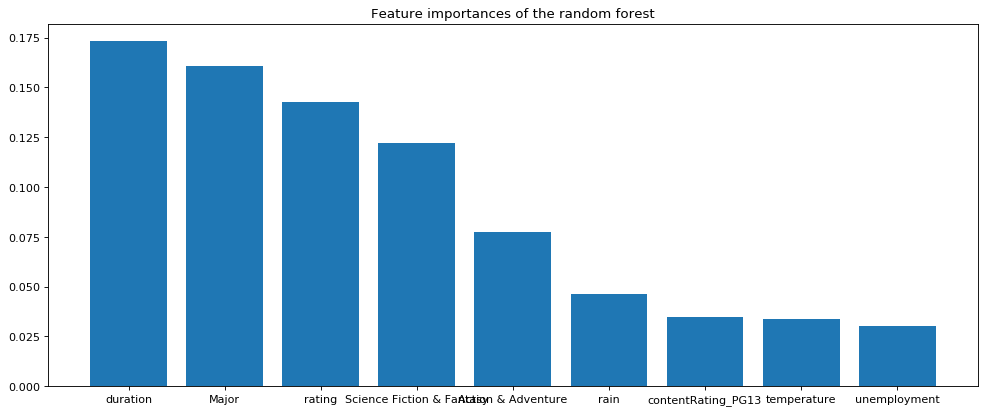

In [238]:
## (best_model.feature_importances_,)
q = rankdata(best_model_rf.feature_importances_).astype('int')

imp = np.concatenate((np.expand_dims(X_train.columns,1),np.expand_dims(best_model_rf.feature_importances_,1)),axis=1)
imp = np.concatenate((imp,np.expand_dims(q,1)),axis=1)
imp =  pd.DataFrame(imp)
imp.columns = ['Feature','Feature weight', 'Feature rank']
imp = imp.sort_values(by='Feature weight', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
y_fig = imp[imp['Feature rank']>56]['Feature weight']
x_fig = np.arange(y_fig.shape[0])

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
my_xticks = imp['Feature']
plt.xticks(x_fig, my_xticks)
plt.bar(x_fig, y_fig)
plt.title('Feature importances of the random forest')
plt.show()


### Interpreting results

feature_importances_ 

## Ada boost 

A word on the hyperparameters we chose to grid over. First, we have to choose your base estimator, which is going to be a regression tree for us, and thus we have to chose all the parameters of the tree. Then, we have to choose the number of trees that we sequentially are going to train, the loss function that is going to define the weights and the learning rate(also known as shrinkage parameter).

In [239]:
#sklearn.ensemble.AdaBoostRegressor(base_estimator=None, n_estimators=, learning_rate=0.01, loss=’linear’)

max_depth_grid = np.arange(1,10,2)
n_estim_grid = np.arange(1000,3000,100)
cross_score = np.zeros((max_depth_grid.shape[0],n_estim_grid.shape[0]))

for index_1,m_depth in enumerate(max_depth_grid):
    
    for index_2,n_estim in enumerate(n_estim_grid):
        
        tree = sklearn.tree.DecisionTreeRegressor(max_depth=m_depth)
        boost = sklearn.ensemble.AdaBoostRegressor(base_estimator=tree, n_estimators=n_estim, learning_rate=0.01, loss='linear')
        scores = cross_val_score(forest, X_train, y_train, cv=5)
        avg_score = sum(scores)/len(scores)
        cross_score[index_1,index_2] = avg_score

        
ind = np.unravel_index(np.argmax(cross_score, axis=None), cross_score.shape)
best_max_depth = max_depth_grid[ind[0]]
best_n_estim = n_estim_grid[ind[1]]

best_tree = sklearn.tree.DecisionTreeRegressor(max_depth=best_max_depth)
best_model_ada = sklearn.ensemble.AdaBoostRegressor(base_estimator=best_tree, n_estimators=best_n_estim, learning_rate=0.01, loss='linear')
best_model_ada.fit(X_train,y_train)

score = best_model_ada.score(X_test,y_test)
print ('best combination of hyperparameters for boosting is  (max_depth, n_estim)', best_max_depth, best_n_estim, 'with out of sample R**2 :', score)


best combination of hyperparameters for boosting is  (max_depth, n_estim) 5 2100 with out of sample R**2 : 0.432226673576


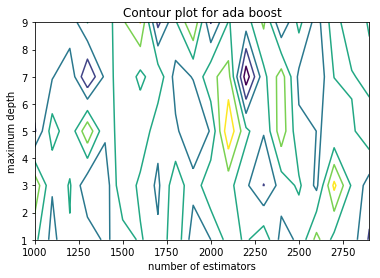

In [240]:
fig = plt.figure()
X_grid, Y_grid = np.meshgrid(n_estim_grid,max_depth_grid)
plt.contour(X_grid,Y_grid,cross_score)
plt.xlabel('number of estimators')
plt.ylabel('maximum depth')
plt.title('Contour plot for ada boost')
plt.show()

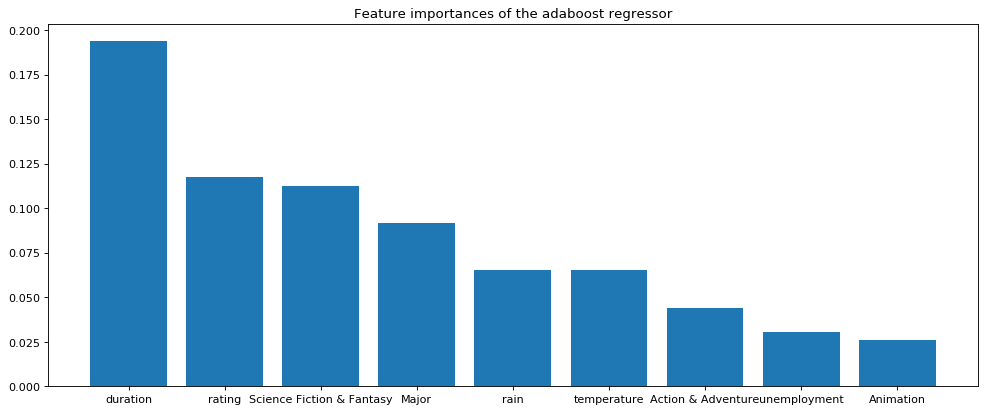

In [241]:
## (best_model.feature_importances_,)
q = rankdata(best_model_ada.feature_importances_).astype('int')

imp = np.concatenate((np.expand_dims(X_train.columns,1),np.expand_dims(best_model_ada.feature_importances_,1)),axis=1)
imp = np.concatenate((imp,np.expand_dims(q,1)),axis=1)
imp =  pd.DataFrame(imp)
imp.columns = ['Feature','Feature weight', 'Feature rank']
imp = imp.sort_values(by='Feature weight', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
y_fig = imp[imp['Feature rank']>56]['Feature weight']
x_fig = np.arange(y_fig.shape[0])

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
my_xticks = imp['Feature']
plt.xticks(x_fig, my_xticks)
plt.bar(x_fig, y_fig)
plt.title('Feature importances of the adaboost regressor')
plt.show()